In [1]:
import tensorflow as tf 
from tensorflow import keras
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import modules.utils as tools
from sklearn.preprocessing import MinMaxScaler

In [323]:
import pickle
with open('Data/pickles/interpolated_data.pkl', 'rb') as f:
    interpolated_data = pickle.load(f)
    #times =interpolated_data[battery_no][cycle_no][:,0]

## Sequence-to-Vector

In [324]:
window_size = 50
forecasting_range = 10

In [325]:
def preprocess_data(interpolated_data, window_size = 50, forecasting_range = 10):
    X = []
    y = []
    for battery_no in range(len(interpolated_data)):
        for cycle_no in range(len(interpolated_data[battery_no])):
            for step in range(len(interpolated_data[battery_no][cycle_no])- window_size - forecasting_range):
                x_row = interpolated_data[battery_no][cycle_no][step:step+window_size,1].tolist()
                y_row = interpolated_data[battery_no][cycle_no][step+window_size:step+window_size+forecasting_range,1]
                X.append(x_row)
                y.append(y_row)

    X = np.array(X).reshape(-1, window_size)
    y = np.array(y).reshape(-1, forecasting_range)
    return X, y



In [326]:
X, y = preprocess_data(interpolated_data)

In [327]:
print(X.shape, y.shape)

(127758, 50) (127758, 10)


In [328]:
all_data = np.concatenate((X, y), axis=1)

In [329]:
def min_max_scaling(all_data):
    minimum = all_data.min()
    maximum = all_data.max()
    return (all_data - minimum)/(maximum-minimum)

    


In [330]:
all_data_scaled = min_max_scaling(all_data)
X = all_data_scaled[:, :window_size]
y = all_data_scaled[:,window_size:]

In [284]:
X[0,:]

array([0.98318768, 0.98300903, 0.96806514, 0.92201743, 0.89353511,
       0.88836564, 0.88400847, 0.88014515, 0.876838  , 0.87366318,
       0.87096122, 0.8683125 , 0.86589868, 0.86358862, 0.86146733,
       0.85947069, 0.857582  , 0.85578246, 0.85401835, 0.85233787,
       0.85067906, 0.84916447, 0.84766052, 0.8461867 , 0.84475775,
       0.84338576, 0.8420199 , 0.84065772, 0.83936292, 0.83808481,
       0.83686026, 0.83564311, 0.83445977, 0.83328816, 0.83213834,
       0.83098531, 0.82982936, 0.82872647, 0.82764531, 0.82659271,
       0.8255412 , 0.82446413, 0.82338786, 0.82231376, 0.82124125,
       0.8201707 , 0.81913531, 0.81812032, 0.81705813, 0.8159855 ])

In [285]:
X = X.reshape(-1, window_size, 1)

In [286]:
from sklearn.model_selection import train_test_split

X_train, X_val_test,y_train, y_val_test = train_test_split(X, y, random_state=42, train_size=0.6)

In [287]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, random_state=42, train_size=0.5)

In [288]:
epochs = 20
baseline_model = keras.models.Sequential()
baseline_model.add(keras.layers.Flatten(input_shape= [window_size, 1]))
baseline_model.add(keras.layers.Dense(10))
baseline_model.compile(optimizer='Adam', loss='mse')
history = baseline_model.fit(X_train, y_train, epochs=epochs, validation_data = (X_val, y_val))


Epoch 1/20
2396/2396 [==============================] - 1s 424us/step - loss: 0.1521 - val_loss: 0.0020
Epoch 2/20
2396/2396 [==============================] - 1s 455us/step - loss: 0.0019 - val_loss: 0.0016
Epoch 3/20
2396/2396 [==============================] - 1s 410us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/20
2396/2396 [==============================] - 1s 430us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 5/20
2396/2396 [==============================] - 1s 381us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/20
2396/2396 [==============================] - 1s 400us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/20
2396/2396 [==============================] - 1s 379us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/20
2396/2396 [==============================] - 1s 451us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/20
2396/2396 [==============================] - 1s 321us/step - loss: 0.0013 - val_loss: 0.0014
Epoch 10/20
2396/2396 [==============================] - 1s 298u

In [289]:
baseline_model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 10)                510       
Total params: 510
Trainable params: 510
Non-trainable params: 0
_________________________________________________________________


In [290]:
base_pred = baseline_model.predict(X_val)

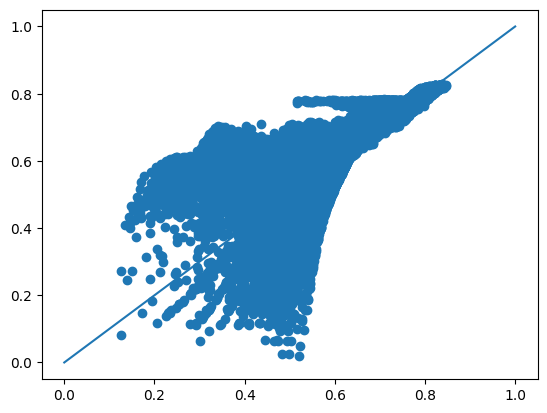

In [291]:
plt.scatter(base_pred, y_val)
x = np.linspace(start=0, stop=1, num=50)
plt.plot(x, x)
plt.show()

In [292]:
y_pred = baseline_model.predict(X_val)
print(y_val[5], y_pred[5])

[0.77632587 0.7750789  0.77392814 0.77271816 0.77163752 0.77036916
 0.76915794 0.76807154 0.76690048 0.76583681] [0.784873   0.779246   0.77859694 0.77420324 0.7629733  0.75763243
 0.754927   0.75522476 0.7523939  0.75424695]


In [294]:
# Simple RNN
simple_rnn_model = keras.models.Sequential()
#simple_rnn_model.add(keras.layers.Flatten(input_shape= [window_size, 1]))
simple_rnn_model.add(keras.layers.SimpleRNN(20, input_shape=[None, 1], activation='sigmoid', return_sequences=True))
simple_rnn_model.add(keras.layers.SimpleRNN(20, activation='sigmoid'))
simple_rnn_model.add(keras.layers.Dense(10))
simple_rnn_model.compile(optimizer='Adam', loss='mse')
simple_rnn_model.summary()
history = simple_rnn_model.fit(X_train, y_train, epochs=8, validation_data = (X_val, y_val))


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_36 (Dense)             (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
2396/2396 [==============================] - 17s 7ms/step - loss: 0.0725 - val_loss: 0.0065
Epoch 2/8
2396/2396 [==============================] - 17s 7ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 3/8
2396/2396 [==============================] - 16s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 4/8
2396/2396 [==============================] - 15s 6ms/step - loss:

In [295]:
y_pred = simple_rnn_model.predict(X_val)

In [296]:
print(y_pred[5], y_val[5])

[0.7754543  0.77210504 0.7674009  0.7682192  0.7648749  0.76843935
 0.76692235 0.7635124  0.76599663 0.7674228 ] [0.77632587 0.7750789  0.77392814 0.77271816 0.77163752 0.77036916
 0.76915794 0.76807154 0.76690048 0.76583681]


In [297]:
X_val.shape

(25552, 50, 1)

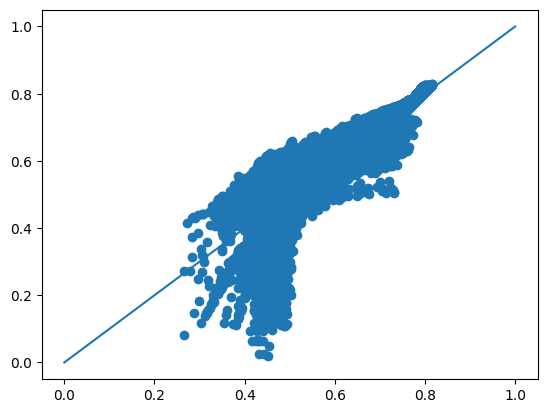

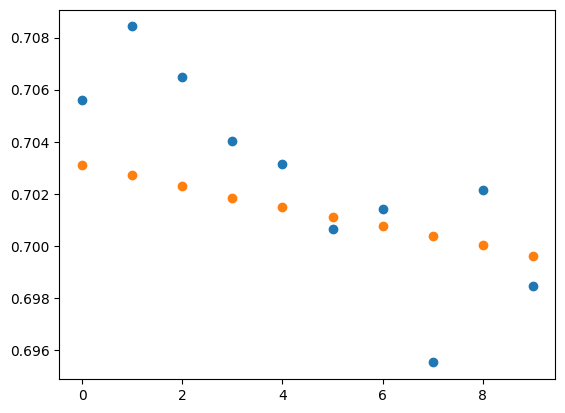

In [300]:
plt.figure()
plt.scatter(y_pred[:,-10:], y_val[:,-10:])
x = np.linspace(start=0, stop=1, num=50)
plt.plot(x, x)
plt.figure()
plt.scatter(np.arange(start=0, stop=len(y_pred[3]), step=1), y_pred[3])
plt.scatter(np.arange(start=0, stop=len(y_val[3]), step=1), y_val[3])

plt.show()

In [ ]:
def predict_curve(model=simple_rnn_model):
    

In [55]:
# LSTM RNN
lstm_rnn_model = keras.models.Sequential()
#simple_rnn_model.add(keras.layers.Flatten(input_shape= [window_size, 1]))
lstm_rnn_model.add(keras.layers.LSTM(20, input_shape=[None, 1], activation='sigmoid', return_sequences=True))
lstm_rnn_model.add(keras.layers.LSTM(20, activation='sigmoid'))
lstm_rnn_model.add(keras.layers.Dense(10))
lstm_rnn_model.compile(optimizer='Adam', loss='mse')
lstm_rnn_model.summary()
history = lstm_rnn_model.fit(X_train, y_train, epochs=6, validation_data = (X_val, y_val))


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
2396/2396 [==============================] - 32s 13ms/step - loss: 0.0688 - val_loss: 0.0028
Epoch 2/6
2396/2396 [==============================] - 32s 14ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 3/6
2396/2396 [==============================] - 29s 12ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/6
2396/2396 [==============================] - 30s 12ms/step - lo

In [56]:
y_pred_lstm = lstm_rnn_model.predict(X_val)
predicted_data_lstm = scaler.inverse_transform(np.concatenate((X_val.reshape(-1,window_size), y_pred_lstm), axis=1))
original_data_lstm = scaler.inverse_transform(np.concatenate((X_val.reshape(-1,window_size), y_val), axis=1))

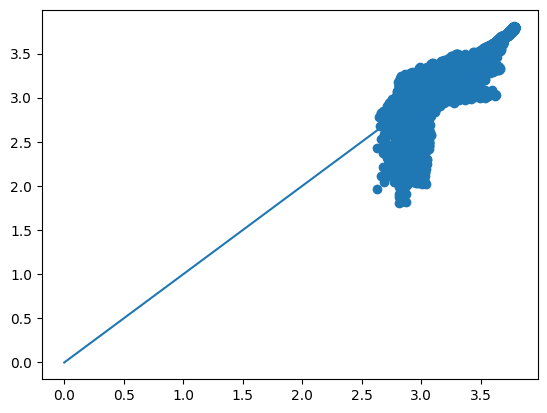

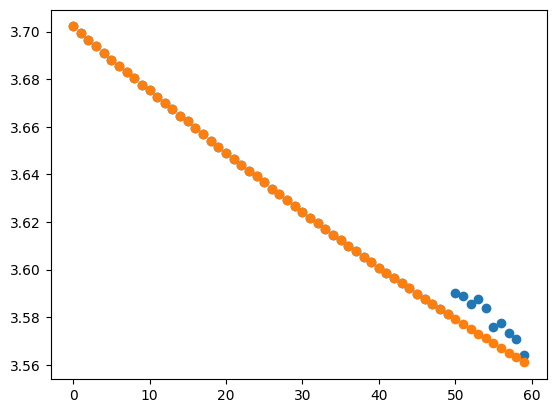

In [59]:
plt.figure()
plt.scatter(predicted_data_lstm[:,-10:], original_data_lstm[:,-10:])
x = np.linspace(start=0, stop=3, num=50)
plt.plot(x, x)
plt.figure()
plt.scatter(np.arange(start=0, stop=len(predicted_data[3]), step=1), predicted_data_lstm[0])
plt.scatter(np.arange(start=0, stop=len(original_data[3]), step=1), original_data_lstm[0])

plt.show()

## Sequence-to-Sequence

In [332]:
#X has shape (# examples, 50, 1) 
#y has shape (# examples, 10)
#Want to construct matrix Y with dimensions (# examples, 50, 10)
X = X.reshape(-1, window_size, 1)
y = y.reshape(-1, forecasting_range, 1)
series = np.concatenate((X, y), axis=1) #dimension (# examples, 60, 1)
series.shape

(127758, 60, 1)

In [333]:
window_size = 50
forecasting_range = 10
Y = np.empty((X.shape[0], window_size, forecasting_range))
for step_ahead in range(1, forecasting_range+1):
    Y[:,:,step_ahead -1] = series[:,step_ahead:step_ahead+window_size,0]

In [334]:
Y.shape

(127758, 50, 10)

In [337]:
Y[0,0,:] # for each point in the timeseries its label is the next 10 successive points 

array([0.98300903, 0.96806514, 0.92201743, 0.89353511, 0.88836564,
       0.88400847, 0.88014515, 0.876838  , 0.87366318, 0.87096122])

In [338]:
X_seq_train, X_seq_valtest, Y_seq_train, Y_seq_valtest = train_test_split(X, Y, random_state=42, train_size=0.6)
X_seq_val, X_seq_test, Y_seq_val, Y_seq_test = train_test_split(X_seq_valtest, Y_seq_valtest, random_state=42, train_size=0.5)


In [339]:
#custom metric for evaluation
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:,-1], Y_pred[:, -1])

In [307]:
seq_lstm_model = keras.models.Sequential()
seq_lstm_model.add(keras.layers.LSTM(20, return_sequences=True, input_shape=[None,1]))
seq_lstm_model.add(keras.layers.LSTM(20, return_sequences=True))
seq_lstm_model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=10, activity_regularizer=keras.regularizers.l2(l2=0.01))))
optimizer = keras.optimizers.Adam(lr=0.01)
seq_lstm_model.compile(optimizer=optimizer, loss="mse", metrics=[last_time_step_mse])

In [308]:
history = seq_lstm_model.fit(X_seq_train, Y_seq_train, epochs=5, validation_data = (X_seq_val, Y_seq_val))

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpjhdvvdsy.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpjhdvvdsy.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2396/2396 [==============================] - 37s 15ms/step - loss: 0.0528 - last_time_step_mse: 0.0107 - val_loss: 0.0452 - val_last_time_step_mse: 0.0041
Epoch 2/5
2396/2396 [==============================] - 32s 14ms/step - loss: 0.0454 - last_time_step_mse: 0.0042 - val_loss: 0.0453 - val_last_time_step_mse: 0.0054
Epoch 3/5
2396/2396 [==============================] - 32s 13ms/st

KeyboardInterrupt: 

In [340]:
Y_seq_pred = wrapped_model.predict(X_seq_val)
#Y_seq_pred = seq_lstm_model.predict(X_seq_val)

In [341]:
Y_seq_pred[0,49,:]

array([0.7337432 , 0.73281425, 0.73087466, 0.72971934, 0.7283597 ,
       0.72786194, 0.7255634 , 0.7234268 , 0.72234666, 0.7211761 ],
      dtype=float32)

In [342]:
Y_seq_val[0,49,:]

array([0.73605321, 0.73525852, 0.73440399, 0.73362271, 0.73278415,
       0.73196578, 0.73117505, 0.73027693, 0.72958185, 0.72872015])

In [343]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(Y_seq_pred[:,49,0],Y_seq_val[:,49,0])

In [344]:
r_value

0.9846681348091908

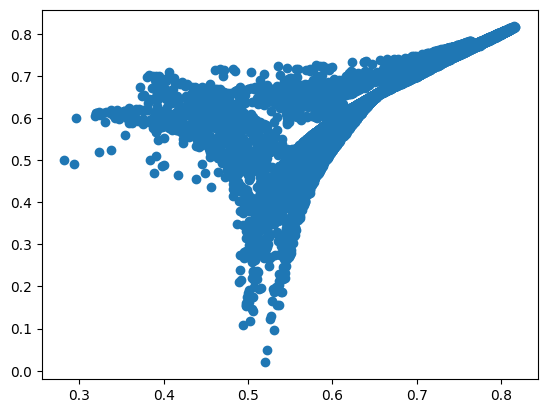

In [345]:
plt.scatter(Y_seq_pred[:,49,9],Y_seq_val[:,49,9])
plt.show()

In [309]:
def build_model(n_neurons=80, n_hidden=1, l2_activity=0.0001, l2_kernel=0, lr=0.01, is_LSTM=True, activation='tanh'):
    model = keras.models.Sequential()
    if is_LSTM:
        model.add(keras.layers.LSTM(units=n_neurons, return_sequences=True, activation=activation, input_shape=[None,1]))
        for layer in range(n_hidden):
            model.add(keras.layers.LSTM(units=n_neurons, return_sequences=True, activation=activation))
    else:
        model.add(keras.layers.SimpleRNN(units=n_neurons, return_sequences=True, activation=activation, input_shape=[None,1]))
        for layer in range(n_hidden):
            model.add(keras.layers.SimpleRNN(units=n_neurons, return_sequences=True, activation=activation))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=10, kernel_regularizer=keras.regularizers.l2(l2=l2_kernel), activity_regularizer=keras.regularizers.l2(l2=l2_activity))))
    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
    return model

In [310]:
wrapped_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [311]:
wrapped_model.fit(X_seq_train, Y_seq_train, epochs=5, validation_data=(X_seq_val, Y_seq_val))

Epoch 1/5
2396/2396 [==============================] - 60s 24ms/step - loss: 0.0073 - last_time_step_mse: 0.0062 - val_loss: 6.6084e-04 - val_last_time_step_mse: 4.1966e-04
Epoch 2/5
2396/2396 [==============================] - 60s 25ms/step - loss: 6.8222e-04 - last_time_step_mse: 4.4768e-04 - val_loss: 6.4730e-04 - val_last_time_step_mse: 3.3717e-04
Epoch 3/5
2396/2396 [==============================] - 61s 25ms/step - loss: 6.4137e-04 - last_time_step_mse: 3.6217e-04 - val_loss: 6.3901e-04 - val_last_time_step_mse: 3.5433e-04
Epoch 4/5
2396/2396 [==============================] - 61s 26ms/step - loss: 6.1773e-04 - last_time_step_mse: 3.1719e-04 - val_loss: 6.6721e-04 - val_last_time_step_mse: 3.5181e-04
Epoch 5/5
2396/2396 [==============================] - 62s 26ms/step - loss: 6.0406e-04 - last_time_step_mse: 3.0212e-04 - val_loss: 6.2432e-04 - val_last_time_step_mse: 2.8471e-04


In [ ]:
from sklearn.model_selection import GridSearchCV

param_distribs = {
    'n_neurons': [5, 10, 20, 30]
}

grid_search_cv = GridSearchCV(wrapped_model, param_distribs, cv=3)
grid_search_cv.fit(X_seq_train, Y_seq_train, epochs=3, validation_data=(X_seq_val, Y_seq_val))

In [165]:
grid_search_cv.best_params_

{'n_neurons': 30}

In [ ]:
wrapped_model.fit(X_seq_train, Y_seq_train, epochs=5, validation_data = (X_seq_val, Y_seq_val))

## Drawing voltage curves

In [218]:
voltages = interpolated_data[0][0][:,1]

In [346]:
def generate_voltage_curve(model=wrapped_model, interpolated_data=interpolated_data, battery_no=0, cycle_no=0, window_size=50, scaler=scaler, forecasting_range=10):
    n_datapoints = len(interpolated_data[battery_no][cycle_no][:,1])
    true_voltages = interpolated_data[battery_no][cycle_no][:,1][:window_size] #1d numpy array
    X = true_voltages.reshape(1, -1)
    assert X.shape[1] == window_size
    dummy_Y = np.zeros((1, forecasting_range))
    XY = np.concatenate((X, dummy_Y), axis=1)
    XY = min_max_scaling(XY)
    X = XY[0, :window_size]
    scaled_predictions = X.reshape(-1, window_size, 1)
    for i in range(round(n_datapoints/forecasting_range)):
        Y = model.predict(scaled_predictions[:,-50:,:]) #Y has shape (50, 10)
        assert Y.shape[0] == window_size
        Y = Y[window_size-1, :] #1d array with 10 elements
        #Y = Y.reshape(-1, forecasting_range)
        Y = Y.reshape(-1, forecasting_range, 1) #making it 3D
        scaled_predictions = np.concatenate((scaled_predictions, Y), axis=1)
    #pred_voltages = scaler.inverse_transform(scaled_predictions.reshape(1,-1))
    #pred_voltages = pred_voltages.reshape(-1) #flattens
    scaled_predictions = scaled_predictions.reshape(-1)
    return scaled_predictions
    

In [347]:
scaled_predictions = generate_voltage_curve(cycle_no=5)

In [348]:
scaled_predictions.shape

(420,)

In [256]:
# true_voltages = interpolated_data[0][5][:,1][:window_size] #1d numpy array
# X = true_voltages.reshape(1, -1)
# assert X.shape[1] == window_size
# dummy_Y = np.zeros((1, forecasting_range))
# XY = np.concatenate((X, dummy_Y), axis=1)
# XY = scaler.transform(XY)
# X = XY[0, :window_size]
# X = X.reshape(-1)

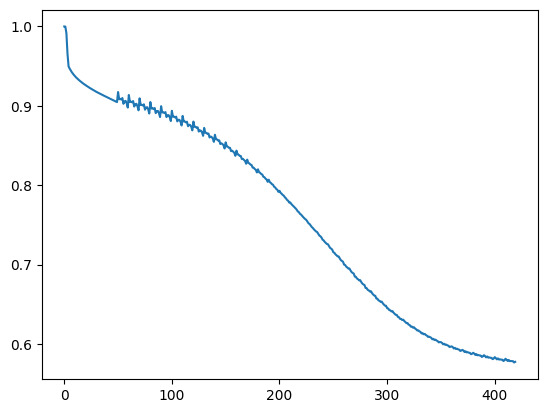

In [349]:
x = np.arange(start=0, stop=len(scaled_predictions), step=1)
#x2 = np.arange(start=0, stop=len(X), step=1)
plt.plot(x, scaled_predictions)
#plt.plot(x2, X)
plt.show()

In [264]:
voltages =interpolated_data[0][0][:,1]
voltages.reshape(-1, window_size)


(370,)

In [266]:
scaler.min_

array([-1.36490955, -1.37340409, -1.3931771 , -1.48314585, -1.5376692 ,
       -1.54931232, -1.5594035 , -1.56861103, -1.57704425, -1.57536677,
       -1.56356858, -1.56964143, -1.57515938, -1.58034075, -1.58524131,
       -1.57150504, -1.57582739, -1.58035225, -1.58489137, -1.58892115,
       -1.59308469, -1.5971665 , -1.60116711, -1.60509921, -1.60522054,
       -1.60921906, -1.61292832, -1.61664531, -1.62026861, -1.6238085 ,
       -1.62716362, -1.63083321, -1.63409848, -1.63741606, -1.64071677,
       -1.64403645, -1.64699867, -1.65014458, -1.52698553, -1.36819195,
       -1.26761096, -1.25932507, -1.17035657, -1.11932584, -1.05153422,
       -1.05310901, -1.05479669, -1.05643965, -1.00461309, -1.006182  ,
       -0.96973362, -0.97127119, -0.91442264, -0.91582174, -0.85979494,
       -0.86100119, -0.86220051, -0.86342448, -0.86468352, -0.865885  ])